# WFlow Model Setup for Catchment FR000119

This notebook initializes and runs the **WFlow** model using **eWaterCycle**, ERA5 forcing, and compares the simulated discharge with observed data for catchment FR000119.

## Importing Python modules

In [1]:
%matplotlib inline
# General python
import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import logging
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.WARN)

# Niceties
from rich import print
from tqdm import tqdm


# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing
from ewatercycle.forcing import sources
import ewatercycle.parameter_sets
from ewatercycle.models import Wflow
from ewatercycle.container import ContainerImage

## Choose parameter set

In [2]:
parameter_set = ewatercycle.parameter_sets.available_parameter_sets()["wflow_rhine_sbm_nc"]
print(parameter_set)

ParameterSet(
    name='wflow_rhine_sbm_nc',
    directory=PosixPath('/data/shared/parameter-sets/wflow_rhine_sbm_nc'),
    config=PosixPath('/data/shared/parameter-sets/wflow_rhine_sbm_nc/wflow_sbm_NC.ini'),
    doi='N/A',
    target_model='wflow',
    supported_model_versions={'2020.1.1', '2020.1.3', '2020.1.2'},
    downloader=None
)

## Generate correct WFlow forcing for FR000119

In [3]:
# name of the catchment
basin_name = "FR000119"

# Define time period and shapefile
wflow_experiment_start_date = "2013-11-26T00:00:00Z"
wflow_experiment_end_date = "2019-12-31T00:00:00Z"
# Set paths and parameters
shapefile_path = Path.home() / "BEP-Elke" / "book" / "thesis_projects" / "BSc" / "2025_Q4_ElkeSchokking_CEG" / "work in progress" / "ShapefilesFR000119" / "FR000119.shp"
dem_file_path = Path("wflow_dem.map")

In [4]:
# Location forcing files in home directory
wflow_forcing_path = Path.home() / "forcing" / "FR000119" / "WFlow_ERA5"
wflow_forcing_path.mkdir(parents=True, exist_ok=True)

In [6]:
# Generate the forcing
# wflow_forcing = sources["WflowForcing"].generate(
#     dataset="ERA5",
#     start_time=wflow_experiment_start_date,
#     end_time=wflow_experiment_end_date,
#     shape=shapefile_path,
#     dem_file=str(dem_file_path.absolute())
# )


# --- Load existing WFlow forcing
wflow_forcing_dir = Path("/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/esmvaltool_output/ewcrepqu50hjmx_20250530_115722/work/diagnostic/script")
wflow_forcing = sources["WflowForcing"].load(directory=wflow_forcing_dir)

print(wflow_forcing)

WflowForcing(
    start_time='2013-11-26T00:00:00Z',
    end_time='2019-12-31T00:00:00Z',
    directory=PosixPath('/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in 
progress/esmvaltool_output/ewcrepqu50hjmx_20250530_115722/work/diagnostic/script'),
    shape=PosixPath('/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in 
progress/esmvaltool_output/ewcrepqu50hjmx_20250530_115722/work/diagnostic/script/FR000119.shp'),
    filenames={},
    netcdfinput='wflow_ERA5_FR000119_2013_2019.nc',
    Precipitation='/pr',
    EvapoTranspiration='/pet',
    Temperature='/tas',
    Inflow=None
)

<xarray.Dataset> Size: 969MB
Dimensions:    (time: 2556, lat: 169, lon: 187, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 20kB 2013-01-01T12:00:00 ... 2019-12-31T...
  * lat        (lat) float64 1kB 52.05 52.02 51.98 51.94 ... 45.97 45.93 45.89
  * lon        (lon) float64 1kB 5.227 5.264 5.3 5.337 ... 11.97 12.01 12.05
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 323MB 8.07 8.07 8.07 ... 0.0 0.0 0.0
    time_bnds  (time, bnds) datetime64[ns] 41kB 2013-01-01 ... 2020-01-01
    lat_bnds   (lat, bnds) float64 3kB 52.07 52.04 52.04 ... 45.91 45.91 45.88
    lon_bnds   (lon, bnds) float64 3kB 5.209 5.245 5.245 ... 12.03 12.03 12.07
    tas        (time, lat, lon) float32 323MB 6.961 6.94 6.902 ... 3.237 4.01
    pet        (time, lat, lon) float32 323MB 0.4312 0.4313 ... 0.494 0.4887
Attributes:
    Conventions:  CF-1.7
    software:     Created with ESMValTool v2.11.1
    caption:      Forcings for the wflow hydrological model.

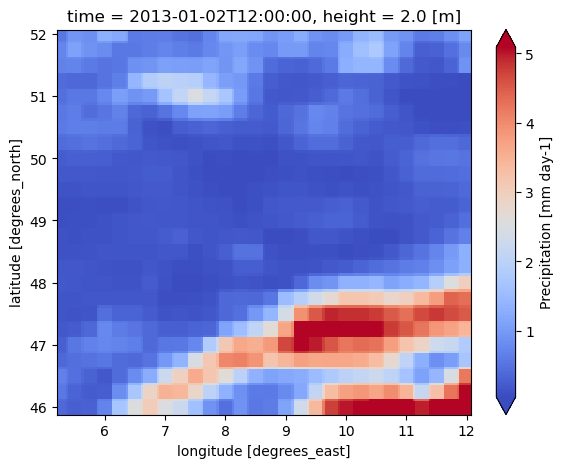

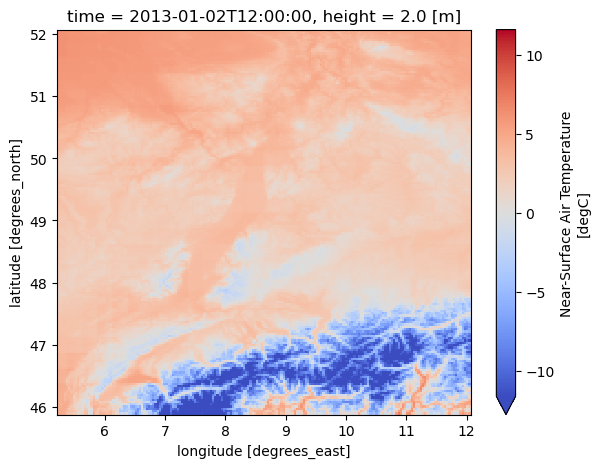

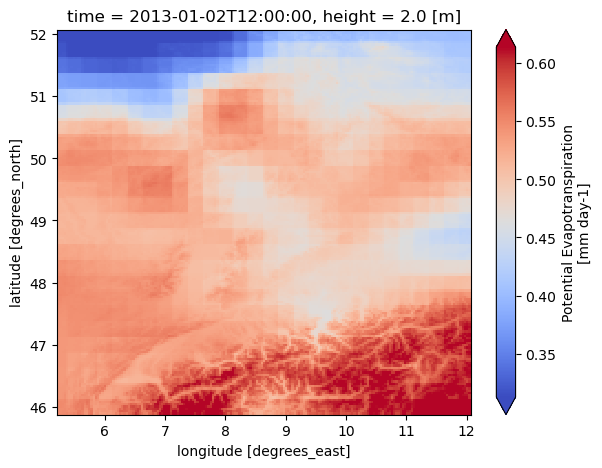

In [7]:
#Plot forcing data
dataset = xr.load_dataset(f"{wflow_forcing.directory}/{wflow_forcing.netcdfinput}")
print(dataset)
for var in ["pr", "tas", "pet"]:
    dataset[var].isel(time=1).plot(cmap="coolwarm", robust=True, size=5)

## Setting up the model
The model needs a parameter set and forcing. The parameter set can be gotten from the available parameters sets on the system and the forcing can derived from the parameter set.

In [8]:
# Create WFlow model
model = ewatercycle.models.Wflow(
    parameter_set=parameter_set,
    forcing=wflow_forcing,
    #bmi_image=ContainerImage("ewatercycle/ewatercycle/wflow-grpc4bmi:2020.1.3"),
    start_time="2013-11-26T00:00:00Z",
    end_time="2019-12-31T00:00:00Z"
)

In [9]:
print(model)

Wflow(
    parameter_set=ParameterSet(
        name='wflow_rhine_sbm_nc',
        directory=PosixPath('/data/shared/parameter-sets/wflow_rhine_sbm_nc'),
        config=PosixPath('/data/shared/parameter-sets/wflow_rhine_sbm_nc/wflow_sbm_NC.ini'),
        doi='N/A',
        target_model='wflow',
        supported_model_versions={'2020.1.1', '2020.1.3', '2020.1.2'},
        downloader=None
    ),
    forcing=WflowForcing(
        start_time='2013-11-26T00:00:00Z',
        end_time='2019-12-31T00:00:00Z',
        directory=PosixPath('/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in 
progress/esmvaltool_output/ewcrepqu50hjmx_20250530_115722/work/diagnostic/script'),
        shape=PosixPath('/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in 
progress/esmvaltool_output/ewcrepqu50hjmx_20250530_115722/work/diagnostic/script/FR000119.shp'),
        filenames={},
        netcdfinput='wflow_ERA5_FR000119_2013_2019.nc',
        Precipitation='/pr',
        EvapoTranspiration='/pet',
        Temperature='/tas',
        Inflow=None
    )
)

In [10]:
import shutil
from pathlib import Path

src = parameter_set.directory / "inmaps.nc"
dst = wflow_forcing.directory / "inmaps.nc"

shutil.copy(src, dst)

PosixPath('/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/esmvaltool_output/ewcrepqu50hjmx_20250530_115722/work/diagnostic/script/inmaps.nc')

In [11]:
cfg_file, cfg_dir = model.setup(end_time="2019-12-31T00:00:00Z")

In [12]:
print(cfg_file)
print(cfg_dir)

/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in 
progress/wflow_20250603_142247/wflow_ewatercycle.ini

/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/wflow_20250603_142247

In [14]:
model.initialize(cfg_file)

In [15]:
while model.time < model.end_time:
    model.update()
    print(model.time_as_isostr)

2013-11-26T00:00:00Z

2013-11-27T00:00:00Z

2013-11-28T00:00:00Z

2013-11-29T00:00:00Z

2013-11-30T00:00:00Z

2013-12-01T00:00:00Z

2013-12-02T00:00:00Z

2013-12-03T00:00:00Z

2013-12-04T00:00:00Z

2013-12-05T00:00:00Z

2013-12-06T00:00:00Z

2013-12-07T00:00:00Z

2013-12-08T00:00:00Z

2013-12-09T00:00:00Z

2013-12-10T00:00:00Z

2013-12-11T00:00:00Z

2013-12-12T00:00:00Z

2013-12-13T00:00:00Z

2013-12-14T00:00:00Z

2013-12-15T00:00:00Z

2013-12-16T00:00:00Z

2013-12-17T00:00:00Z

2013-12-18T00:00:00Z

2013-12-19T00:00:00Z

2013-12-20T00:00:00Z

2013-12-21T00:00:00Z

2013-12-22T00:00:00Z

2013-12-23T00:00:00Z

2013-12-24T00:00:00Z

2013-12-25T00:00:00Z

2013-12-26T00:00:00Z

2013-12-27T00:00:00Z

2013-12-28T00:00:00Z

2013-12-29T00:00:00Z

2013-12-30T00:00:00Z

2013-12-31T00:00:00Z

2014-01-01T00:00:00Z

2014-01-02T00:00:00Z

2014-01-03T00:00:00Z

2014-01-04T00:00:00Z

2014-01-05T00:00:00Z

2014-01-06T00:00:00Z

2014-01-07T00:00:00Z

2014-01-08T00:00:00Z

2014-01-09T00:00:00Z

2014-01-10T00:00:00Z

2014-01-11T00:00:00Z

2014-01-12T00:00:00Z

2014-01-13T00:00:00Z

2014-01-14T00:00:00Z

2014-01-15T00:00:00Z

2014-01-16T00:00:00Z

2014-01-17T00:00:00Z

2014-01-18T00:00:00Z

2014-01-19T00:00:00Z

2014-01-20T00:00:00Z

2014-01-21T00:00:00Z

2014-01-22T00:00:00Z

2014-01-23T00:00:00Z

2014-01-24T00:00:00Z

2014-01-25T00:00:00Z

2014-01-26T00:00:00Z

2014-01-27T00:00:00Z

2014-01-28T00:00:00Z

2014-01-29T00:00:00Z

2014-01-30T00:00:00Z

2014-01-31T00:00:00Z

2014-02-01T00:00:00Z

2014-02-02T00:00:00Z

2014-02-03T00:00:00Z

2014-02-04T00:00:00Z

2014-02-05T00:00:00Z

2014-02-06T00:00:00Z

2014-02-07T00:00:00Z

2014-02-08T00:00:00Z

2014-02-09T00:00:00Z

2014-02-10T00:00:00Z

2014-02-11T00:00:00Z

2014-02-12T00:00:00Z

2014-02-13T00:00:00Z

2014-02-14T00:00:00Z

2014-02-15T00:00:00Z

2014-02-16T00:00:00Z

2014-02-17T00:00:00Z

2014-02-18T00:00:00Z

2014-02-19T00:00:00Z

2014-02-20T00:00:00Z

2014-02-21T00:00:00Z

2014-02-22T00:00:00Z

2014-02-23T00:00:00Z

2014-02-24T00:00:00Z

2014-02-25T00:00:00Z

2014-02-26T00:00:00Z

2014-02-27T00:00:00Z

2014-02-28T00:00:00Z

2014-03-01T00:00:00Z

2014-03-02T00:00:00Z

2014-03-03T00:00:00Z

2014-03-04T00:00:00Z

2014-03-05T00:00:00Z

2014-03-06T00:00:00Z

2014-03-07T00:00:00Z

2014-03-08T00:00:00Z

2014-03-09T00:00:00Z

2014-03-10T00:00:00Z

2014-03-11T00:00:00Z

2014-03-12T00:00:00Z

2014-03-13T00:00:00Z

2014-03-14T00:00:00Z

2014-03-15T00:00:00Z

2014-03-16T00:00:00Z

2014-03-17T00:00:00Z

2014-03-18T00:00:00Z

2014-03-19T00:00:00Z

2014-03-20T00:00:00Z

2014-03-21T00:00:00Z

2014-03-22T00:00:00Z

2014-03-23T00:00:00Z

2014-03-24T00:00:00Z

2014-03-25T00:00:00Z

2014-03-26T00:00:00Z

2014-03-27T00:00:00Z

2014-03-28T00:00:00Z

2014-03-29T00:00:00Z

2014-03-30T00:00:00Z

2014-03-31T00:00:00Z

2014-04-01T00:00:00Z

2014-04-02T00:00:00Z

2014-04-03T00:00:00Z

2014-04-04T00:00:00Z

2014-04-05T00:00:00Z

2014-04-06T00:00:00Z

2014-04-07T00:00:00Z

2014-04-08T00:00:00Z

2014-04-09T00:00:00Z

2014-04-10T00:00:00Z

2014-04-11T00:00:00Z

2014-04-12T00:00:00Z

2014-04-13T00:00:00Z

2014-04-14T00:00:00Z

2014-04-15T00:00:00Z

2014-04-16T00:00:00Z

2014-04-17T00:00:00Z

2014-04-18T00:00:00Z

2014-04-19T00:00:00Z

2014-04-20T00:00:00Z

2014-04-21T00:00:00Z

2014-04-22T00:00:00Z

2014-04-23T00:00:00Z

2014-04-24T00:00:00Z

2014-04-25T00:00:00Z

2014-04-26T00:00:00Z

2014-04-27T00:00:00Z

2014-04-28T00:00:00Z

2014-04-29T00:00:00Z

2014-04-30T00:00:00Z

2014-05-01T00:00:00Z

2014-05-02T00:00:00Z

2014-05-03T00:00:00Z

2014-05-04T00:00:00Z

2014-05-05T00:00:00Z

2014-05-06T00:00:00Z

2014-05-07T00:00:00Z

2014-05-08T00:00:00Z

2014-05-09T00:00:00Z

2014-05-10T00:00:00Z

2014-05-11T00:00:00Z

2014-05-12T00:00:00Z

2014-05-13T00:00:00Z

2014-05-14T00:00:00Z

2014-05-15T00:00:00Z

2014-05-16T00:00:00Z

2014-05-17T00:00:00Z

2014-05-18T00:00:00Z

2014-05-19T00:00:00Z

2014-05-20T00:00:00Z

2014-05-21T00:00:00Z

2014-05-22T00:00:00Z

2014-05-23T00:00:00Z

2014-05-24T00:00:00Z

2014-05-25T00:00:00Z

2014-05-26T00:00:00Z

2014-05-27T00:00:00Z

2014-05-28T00:00:00Z

2014-05-29T00:00:00Z

2014-05-30T00:00:00Z

2014-05-31T00:00:00Z

2014-06-01T00:00:00Z

2014-06-02T00:00:00Z

2014-06-03T00:00:00Z

2014-06-04T00:00:00Z

2014-06-05T00:00:00Z

2014-06-06T00:00:00Z

2014-06-07T00:00:00Z

2014-06-08T00:00:00Z

2014-06-09T00:00:00Z

2014-06-10T00:00:00Z

2014-06-11T00:00:00Z

2014-06-12T00:00:00Z

2014-06-13T00:00:00Z

2014-06-14T00:00:00Z

2014-06-15T00:00:00Z

2014-06-16T00:00:00Z

2014-06-17T00:00:00Z

2014-06-18T00:00:00Z

2014-06-19T00:00:00Z

2014-06-20T00:00:00Z

2014-06-21T00:00:00Z

2014-06-22T00:00:00Z

2014-06-23T00:00:00Z

2014-06-24T00:00:00Z

2014-06-25T00:00:00Z

2014-06-26T00:00:00Z

2014-06-27T00:00:00Z

2014-06-28T00:00:00Z

2014-06-29T00:00:00Z

2014-06-30T00:00:00Z

2014-07-01T00:00:00Z

2014-07-02T00:00:00Z

2014-07-03T00:00:00Z

2014-07-04T00:00:00Z

2014-07-05T00:00:00Z

2014-07-06T00:00:00Z

2014-07-07T00:00:00Z

2014-07-08T00:00:00Z

2014-07-09T00:00:00Z

2014-07-10T00:00:00Z

2014-07-11T00:00:00Z

2014-07-12T00:00:00Z

2014-07-13T00:00:00Z

2014-07-14T00:00:00Z

2014-07-15T00:00:00Z

2014-07-16T00:00:00Z

2014-07-17T00:00:00Z

2014-07-18T00:00:00Z

2014-07-19T00:00:00Z

2014-07-20T00:00:00Z

2014-07-21T00:00:00Z

2014-07-22T00:00:00Z

2014-07-23T00:00:00Z

2014-07-24T00:00:00Z

2014-07-25T00:00:00Z

2014-07-26T00:00:00Z

2014-07-27T00:00:00Z

2014-07-28T00:00:00Z

2014-07-29T00:00:00Z

2014-07-30T00:00:00Z

2014-07-31T00:00:00Z

2014-08-01T00:00:00Z

2014-08-02T00:00:00Z

2014-08-03T00:00:00Z

2014-08-04T00:00:00Z

2014-08-05T00:00:00Z

2014-08-06T00:00:00Z

2014-08-07T00:00:00Z

2014-08-08T00:00:00Z

2014-08-09T00:00:00Z

2014-08-10T00:00:00Z

2014-08-11T00:00:00Z

2014-08-12T00:00:00Z

2014-08-13T00:00:00Z

2014-08-14T00:00:00Z

2014-08-15T00:00:00Z

2014-08-16T00:00:00Z

2014-08-17T00:00:00Z

2014-08-18T00:00:00Z

2014-08-19T00:00:00Z

2014-08-20T00:00:00Z

2014-08-21T00:00:00Z

2014-08-22T00:00:00Z

2014-08-23T00:00:00Z

2014-08-24T00:00:00Z

2014-08-25T00:00:00Z

2014-08-26T00:00:00Z

2014-08-27T00:00:00Z

2014-08-28T00:00:00Z

2014-08-29T00:00:00Z

2014-08-30T00:00:00Z

2014-08-31T00:00:00Z

2014-09-01T00:00:00Z

2014-09-02T00:00:00Z

2014-09-03T00:00:00Z

2014-09-04T00:00:00Z

2014-09-05T00:00:00Z

2014-09-06T00:00:00Z

2014-09-07T00:00:00Z

2014-09-08T00:00:00Z

2014-09-09T00:00:00Z

2014-09-10T00:00:00Z

2014-09-11T00:00:00Z

2014-09-12T00:00:00Z

2014-09-13T00:00:00Z

2014-09-14T00:00:00Z

2014-09-15T00:00:00Z

2014-09-16T00:00:00Z

2014-09-17T00:00:00Z

2014-09-18T00:00:00Z

2014-09-19T00:00:00Z

2014-09-20T00:00:00Z

2014-09-21T00:00:00Z

2014-09-22T00:00:00Z

2014-09-23T00:00:00Z

2014-09-24T00:00:00Z

2014-09-25T00:00:00Z

2014-09-26T00:00:00Z

2014-09-27T00:00:00Z

2014-09-28T00:00:00Z

2014-09-29T00:00:00Z

2014-09-30T00:00:00Z

2014-10-01T00:00:00Z

2014-10-02T00:00:00Z

2014-10-03T00:00:00Z

2014-10-04T00:00:00Z

2014-10-05T00:00:00Z

2014-10-06T00:00:00Z

2014-10-07T00:00:00Z

2014-10-08T00:00:00Z

2014-10-09T00:00:00Z

2014-10-10T00:00:00Z

2014-10-11T00:00:00Z

2014-10-12T00:00:00Z

2014-10-13T00:00:00Z

2014-10-14T00:00:00Z

2014-10-15T00:00:00Z

2014-10-16T00:00:00Z

2014-10-17T00:00:00Z

2014-10-18T00:00:00Z

2014-10-19T00:00:00Z

2014-10-20T00:00:00Z

2014-10-21T00:00:00Z

2014-10-22T00:00:00Z

2014-10-23T00:00:00Z

2014-10-24T00:00:00Z

2014-10-25T00:00:00Z

2014-10-26T00:00:00Z

2014-10-27T00:00:00Z

2014-10-28T00:00:00Z

2014-10-29T00:00:00Z

2014-10-30T00:00:00Z

2014-10-31T00:00:00Z

2014-11-01T00:00:00Z

2014-11-02T00:00:00Z

2014-11-03T00:00:00Z

2014-11-04T00:00:00Z

2014-11-05T00:00:00Z

2014-11-06T00:00:00Z

2014-11-07T00:00:00Z

2014-11-08T00:00:00Z

2014-11-09T00:00:00Z

2014-11-10T00:00:00Z

2014-11-11T00:00:00Z

2014-11-12T00:00:00Z

2014-11-13T00:00:00Z

2014-11-14T00:00:00Z

2014-11-15T00:00:00Z

2014-11-16T00:00:00Z

2014-11-17T00:00:00Z

2014-11-18T00:00:00Z

2014-11-19T00:00:00Z

2014-11-20T00:00:00Z

2014-11-21T00:00:00Z

2014-11-22T00:00:00Z

2014-11-23T00:00:00Z

2014-11-24T00:00:00Z

2014-11-25T00:00:00Z

2014-11-26T00:00:00Z

2014-11-27T00:00:00Z

2014-11-28T00:00:00Z

2014-11-29T00:00:00Z

2014-11-30T00:00:00Z

2014-12-01T00:00:00Z

2014-12-02T00:00:00Z

2014-12-03T00:00:00Z

2014-12-04T00:00:00Z

2014-12-05T00:00:00Z

2014-12-06T00:00:00Z

2014-12-07T00:00:00Z

2014-12-08T00:00:00Z

2014-12-09T00:00:00Z

2014-12-10T00:00:00Z

2014-12-11T00:00:00Z

2014-12-12T00:00:00Z

2014-12-13T00:00:00Z

2014-12-14T00:00:00Z

2014-12-15T00:00:00Z

2014-12-16T00:00:00Z

2014-12-17T00:00:00Z

2014-12-18T00:00:00Z

2014-12-19T00:00:00Z

2014-12-20T00:00:00Z

2014-12-21T00:00:00Z

2014-12-22T00:00:00Z

2014-12-23T00:00:00Z

2014-12-24T00:00:00Z

2014-12-25T00:00:00Z

2014-12-26T00:00:00Z

2014-12-27T00:00:00Z

2014-12-28T00:00:00Z

2014-12-29T00:00:00Z

2014-12-30T00:00:00Z

2014-12-31T00:00:00Z

2015-01-01T00:00:00Z

2015-01-02T00:00:00Z

2015-01-03T00:00:00Z

2015-01-04T00:00:00Z

2015-01-05T00:00:00Z

2015-01-06T00:00:00Z

2015-01-07T00:00:00Z

2015-01-08T00:00:00Z

2015-01-09T00:00:00Z

2015-01-10T00:00:00Z

2015-01-11T00:00:00Z

2015-01-12T00:00:00Z

2015-01-13T00:00:00Z

2015-01-14T00:00:00Z

2015-01-15T00:00:00Z

2015-01-16T00:00:00Z

2015-01-17T00:00:00Z

2015-01-18T00:00:00Z

2015-01-19T00:00:00Z

2015-01-20T00:00:00Z

2015-01-21T00:00:00Z

2015-01-22T00:00:00Z

2015-01-23T00:00:00Z

2015-01-24T00:00:00Z

2015-01-25T00:00:00Z

2015-01-26T00:00:00Z

2015-01-27T00:00:00Z

2015-01-28T00:00:00Z

2015-01-29T00:00:00Z

2015-01-30T00:00:00Z

2015-01-31T00:00:00Z

2015-02-01T00:00:00Z

2015-02-02T00:00:00Z

2015-02-03T00:00:00Z

2015-02-04T00:00:00Z

2015-02-05T00:00:00Z

2015-02-06T00:00:00Z

2015-02-07T00:00:00Z

2015-02-08T00:00:00Z

2015-02-09T00:00:00Z

2015-02-10T00:00:00Z

2015-02-11T00:00:00Z

2015-02-12T00:00:00Z

2015-02-13T00:00:00Z

2015-02-14T00:00:00Z

2015-02-15T00:00:00Z

2015-02-16T00:00:00Z

2015-02-17T00:00:00Z

2015-02-18T00:00:00Z

2015-02-19T00:00:00Z

2015-02-20T00:00:00Z

2015-02-21T00:00:00Z

2015-02-22T00:00:00Z

2015-02-23T00:00:00Z

2015-02-24T00:00:00Z

2015-02-25T00:00:00Z

2015-02-26T00:00:00Z

2015-02-27T00:00:00Z

2015-02-28T00:00:00Z

2015-03-01T00:00:00Z

2015-03-02T00:00:00Z

2015-03-03T00:00:00Z

2015-03-04T00:00:00Z

2015-03-05T00:00:00Z

2015-03-06T00:00:00Z

2015-03-07T00:00:00Z

2015-03-08T00:00:00Z

2015-03-09T00:00:00Z

2015-03-10T00:00:00Z

2015-03-11T00:00:00Z

2015-03-12T00:00:00Z

2015-03-13T00:00:00Z

2015-03-14T00:00:00Z

2015-03-15T00:00:00Z

2015-03-16T00:00:00Z

2015-03-17T00:00:00Z

2015-03-18T00:00:00Z

2015-03-19T00:00:00Z

2015-03-20T00:00:00Z

2015-03-21T00:00:00Z

2015-03-22T00:00:00Z

2015-03-23T00:00:00Z

2015-03-24T00:00:00Z

2015-03-25T00:00:00Z

2015-03-26T00:00:00Z

2015-03-27T00:00:00Z

2015-03-28T00:00:00Z

2015-03-29T00:00:00Z

2015-03-30T00:00:00Z

2015-03-31T00:00:00Z

2015-04-01T00:00:00Z

2015-04-02T00:00:00Z

2015-04-03T00:00:00Z

2015-04-04T00:00:00Z

2015-04-05T00:00:00Z

2015-04-06T00:00:00Z

2015-04-07T00:00:00Z

2015-04-08T00:00:00Z

2015-04-09T00:00:00Z

2015-04-10T00:00:00Z

2015-04-11T00:00:00Z

2015-04-12T00:00:00Z

2015-04-13T00:00:00Z

2015-04-14T00:00:00Z

2015-04-15T00:00:00Z

2015-04-16T00:00:00Z

2015-04-17T00:00:00Z

2015-04-18T00:00:00Z

2015-04-19T00:00:00Z

2015-04-20T00:00:00Z

2015-04-21T00:00:00Z

2015-04-22T00:00:00Z

2015-04-23T00:00:00Z

2015-04-24T00:00:00Z

2015-04-25T00:00:00Z

2015-04-26T00:00:00Z

2015-04-27T00:00:00Z

2015-04-28T00:00:00Z

2015-04-29T00:00:00Z

2015-04-30T00:00:00Z

2015-05-01T00:00:00Z

2015-05-02T00:00:00Z

2015-05-03T00:00:00Z

2015-05-04T00:00:00Z

2015-05-05T00:00:00Z

2015-05-06T00:00:00Z

2015-05-07T00:00:00Z

2015-05-08T00:00:00Z

2015-05-09T00:00:00Z

2015-05-10T00:00:00Z

2015-05-11T00:00:00Z

2015-05-12T00:00:00Z

2015-05-13T00:00:00Z

2015-05-14T00:00:00Z

2015-05-15T00:00:00Z

2015-05-16T00:00:00Z

2015-05-17T00:00:00Z

2015-05-18T00:00:00Z

2015-05-19T00:00:00Z

2015-05-20T00:00:00Z

2015-05-21T00:00:00Z

2015-05-22T00:00:00Z

2015-05-23T00:00:00Z

2015-05-24T00:00:00Z

2015-05-25T00:00:00Z

2015-05-26T00:00:00Z

2015-05-27T00:00:00Z

2015-05-28T00:00:00Z

2015-05-29T00:00:00Z

2015-05-30T00:00:00Z

2015-05-31T00:00:00Z

2015-06-01T00:00:00Z

2015-06-02T00:00:00Z

2015-06-03T00:00:00Z

2015-06-04T00:00:00Z

2015-06-05T00:00:00Z

2015-06-06T00:00:00Z

2015-06-07T00:00:00Z

2015-06-08T00:00:00Z

2015-06-09T00:00:00Z

2015-06-10T00:00:00Z

2015-06-11T00:00:00Z

2015-06-12T00:00:00Z

2015-06-13T00:00:00Z

2015-06-14T00:00:00Z

2015-06-15T00:00:00Z

2015-06-16T00:00:00Z

2015-06-17T00:00:00Z

2015-06-18T00:00:00Z

2015-06-19T00:00:00Z

2015-06-20T00:00:00Z

2015-06-21T00:00:00Z

2015-06-22T00:00:00Z

2015-06-23T00:00:00Z

2015-06-24T00:00:00Z

2015-06-25T00:00:00Z

2015-06-26T00:00:00Z

2015-06-27T00:00:00Z

2015-06-28T00:00:00Z

2015-06-29T00:00:00Z

2015-06-30T00:00:00Z

2015-07-01T00:00:00Z

2015-07-02T00:00:00Z

2015-07-03T00:00:00Z

2015-07-04T00:00:00Z

2015-07-05T00:00:00Z

2015-07-06T00:00:00Z

2015-07-07T00:00:00Z

2015-07-08T00:00:00Z

2015-07-09T00:00:00Z

2015-07-10T00:00:00Z

2015-07-11T00:00:00Z

2015-07-12T00:00:00Z

2015-07-13T00:00:00Z

2015-07-14T00:00:00Z

2015-07-15T00:00:00Z

2015-07-16T00:00:00Z

2015-07-17T00:00:00Z

2015-07-18T00:00:00Z

2015-07-19T00:00:00Z

2015-07-20T00:00:00Z

2015-07-21T00:00:00Z

2015-07-22T00:00:00Z

2015-07-23T00:00:00Z

2015-07-24T00:00:00Z

2015-07-25T00:00:00Z

2015-07-26T00:00:00Z

2015-07-27T00:00:00Z

2015-07-28T00:00:00Z

2015-07-29T00:00:00Z

2015-07-30T00:00:00Z

2015-07-31T00:00:00Z

2015-08-01T00:00:00Z

2015-08-02T00:00:00Z

2015-08-03T00:00:00Z

2015-08-04T00:00:00Z

2015-08-05T00:00:00Z

2015-08-06T00:00:00Z

2015-08-07T00:00:00Z

2015-08-08T00:00:00Z

2015-08-09T00:00:00Z

2015-08-10T00:00:00Z

2015-08-11T00:00:00Z

2015-08-12T00:00:00Z

2015-08-13T00:00:00Z

2015-08-14T00:00:00Z

2015-08-15T00:00:00Z

2015-08-16T00:00:00Z

2015-08-17T00:00:00Z

2015-08-18T00:00:00Z

2015-08-19T00:00:00Z

2015-08-20T00:00:00Z

2015-08-21T00:00:00Z

2015-08-22T00:00:00Z

2015-08-23T00:00:00Z

2015-08-24T00:00:00Z

2015-08-25T00:00:00Z

2015-08-26T00:00:00Z

2015-08-27T00:00:00Z

2015-08-28T00:00:00Z

2015-08-29T00:00:00Z

2015-08-30T00:00:00Z

2015-08-31T00:00:00Z

2015-09-01T00:00:00Z

2015-09-02T00:00:00Z

2015-09-03T00:00:00Z

2015-09-04T00:00:00Z

2015-09-05T00:00:00Z

2015-09-06T00:00:00Z

2015-09-07T00:00:00Z

2015-09-08T00:00:00Z

2015-09-09T00:00:00Z

2015-09-10T00:00:00Z

2015-09-11T00:00:00Z

2015-09-12T00:00:00Z

2015-09-13T00:00:00Z

2015-09-14T00:00:00Z

2015-09-15T00:00:00Z

2015-09-16T00:00:00Z

2015-09-17T00:00:00Z

2015-09-18T00:00:00Z

2015-09-19T00:00:00Z

2015-09-20T00:00:00Z

2015-09-21T00:00:00Z

2015-09-22T00:00:00Z

2015-09-23T00:00:00Z

2015-09-24T00:00:00Z

2015-09-25T00:00:00Z

2015-09-26T00:00:00Z

2015-09-27T00:00:00Z

2015-09-28T00:00:00Z

2015-09-29T00:00:00Z

2015-09-30T00:00:00Z

2015-10-01T00:00:00Z

2015-10-02T00:00:00Z

2015-10-03T00:00:00Z

2015-10-04T00:00:00Z

2015-10-05T00:00:00Z

2015-10-06T00:00:00Z

2015-10-07T00:00:00Z

2015-10-08T00:00:00Z

2015-10-09T00:00:00Z

2015-10-10T00:00:00Z

2015-10-11T00:00:00Z

2015-10-12T00:00:00Z

2015-10-13T00:00:00Z

2015-10-14T00:00:00Z

2015-10-15T00:00:00Z

2015-10-16T00:00:00Z

2015-10-17T00:00:00Z

2015-10-18T00:00:00Z

2015-10-19T00:00:00Z

2015-10-20T00:00:00Z

2015-10-21T00:00:00Z

2015-10-22T00:00:00Z

2015-10-23T00:00:00Z

2015-10-24T00:00:00Z

2015-10-25T00:00:00Z

2015-10-26T00:00:00Z

2015-10-27T00:00:00Z

2015-10-28T00:00:00Z

2015-10-29T00:00:00Z

2015-10-30T00:00:00Z

2015-10-31T00:00:00Z

2015-11-01T00:00:00Z

2015-11-02T00:00:00Z

2015-11-03T00:00:00Z

2015-11-04T00:00:00Z

2015-11-05T00:00:00Z

2015-11-06T00:00:00Z

2015-11-07T00:00:00Z

2015-11-08T00:00:00Z

2015-11-09T00:00:00Z

2015-11-10T00:00:00Z

2015-11-11T00:00:00Z

2015-11-12T00:00:00Z

2015-11-13T00:00:00Z

2015-11-14T00:00:00Z

2015-11-15T00:00:00Z

2015-11-16T00:00:00Z

2015-11-17T00:00:00Z

2015-11-18T00:00:00Z

2015-11-19T00:00:00Z

2015-11-20T00:00:00Z

2015-11-21T00:00:00Z

2015-11-22T00:00:00Z

2015-11-23T00:00:00Z

2015-11-24T00:00:00Z

2015-11-25T00:00:00Z

2015-11-26T00:00:00Z

2015-11-27T00:00:00Z

2015-11-28T00:00:00Z

2015-11-29T00:00:00Z

2015-11-30T00:00:00Z

2015-12-01T00:00:00Z

2015-12-02T00:00:00Z

2015-12-03T00:00:00Z

2015-12-04T00:00:00Z

2015-12-05T00:00:00Z

2015-12-06T00:00:00Z

2015-12-07T00:00:00Z

2015-12-08T00:00:00Z

2015-12-09T00:00:00Z

2015-12-10T00:00:00Z

2015-12-11T00:00:00Z

2015-12-12T00:00:00Z

2015-12-13T00:00:00Z

2015-12-14T00:00:00Z

2015-12-15T00:00:00Z

2015-12-16T00:00:00Z

2015-12-17T00:00:00Z

2015-12-18T00:00:00Z

2015-12-19T00:00:00Z

2015-12-20T00:00:00Z

2015-12-21T00:00:00Z

2015-12-22T00:00:00Z

2015-12-23T00:00:00Z

2015-12-24T00:00:00Z

2015-12-25T00:00:00Z

2015-12-26T00:00:00Z

2015-12-27T00:00:00Z

2015-12-28T00:00:00Z

2015-12-29T00:00:00Z

2015-12-30T00:00:00Z

2015-12-31T00:00:00Z

2016-01-01T00:00:00Z

2016-01-02T00:00:00Z

2016-01-03T00:00:00Z

2016-01-04T00:00:00Z

2016-01-05T00:00:00Z

2016-01-06T00:00:00Z

2016-01-07T00:00:00Z

2016-01-08T00:00:00Z

2016-01-09T00:00:00Z

2016-01-10T00:00:00Z

2016-01-11T00:00:00Z

2016-01-12T00:00:00Z

2016-01-13T00:00:00Z

2016-01-14T00:00:00Z

2016-01-15T00:00:00Z

2016-01-16T00:00:00Z

2016-01-17T00:00:00Z

2016-01-18T00:00:00Z

2016-01-19T00:00:00Z

2016-01-20T00:00:00Z

2016-01-21T00:00:00Z

2016-01-22T00:00:00Z

2016-01-23T00:00:00Z

2016-01-24T00:00:00Z

2016-01-25T00:00:00Z

2016-01-26T00:00:00Z

2016-01-27T00:00:00Z

2016-01-28T00:00:00Z

2016-01-29T00:00:00Z

2016-01-30T00:00:00Z

2016-01-31T00:00:00Z

2016-02-01T00:00:00Z

2016-02-02T00:00:00Z

2016-02-03T00:00:00Z

2016-02-04T00:00:00Z

2016-02-05T00:00:00Z

2016-02-06T00:00:00Z

2016-02-07T00:00:00Z

2016-02-08T00:00:00Z

2016-02-09T00:00:00Z

2016-02-10T00:00:00Z

2016-02-11T00:00:00Z

2016-02-12T00:00:00Z

2016-02-13T00:00:00Z

2016-02-14T00:00:00Z

2016-02-15T00:00:00Z

2016-02-16T00:00:00Z

2016-02-17T00:00:00Z

2016-02-18T00:00:00Z

2016-02-19T00:00:00Z

2016-02-20T00:00:00Z

2016-02-21T00:00:00Z

2016-02-22T00:00:00Z

2016-02-23T00:00:00Z

2016-02-24T00:00:00Z

2016-02-25T00:00:00Z

2016-02-26T00:00:00Z

2016-02-27T00:00:00Z

2016-02-28T00:00:00Z

2016-02-29T00:00:00Z

2016-03-01T00:00:00Z

2016-03-02T00:00:00Z

2016-03-03T00:00:00Z

2016-03-04T00:00:00Z

2016-03-05T00:00:00Z

2016-03-06T00:00:00Z

2016-03-07T00:00:00Z

2016-03-08T00:00:00Z

2016-03-09T00:00:00Z

2016-03-10T00:00:00Z

2016-03-11T00:00:00Z

2016-03-12T00:00:00Z

2016-03-13T00:00:00Z

2016-03-14T00:00:00Z

2016-03-15T00:00:00Z

2016-03-16T00:00:00Z

2016-03-17T00:00:00Z

2016-03-18T00:00:00Z

2016-03-19T00:00:00Z

2016-03-20T00:00:00Z

2016-03-21T00:00:00Z

2016-03-22T00:00:00Z

2016-03-23T00:00:00Z

2016-03-24T00:00:00Z

2016-03-25T00:00:00Z

2016-03-26T00:00:00Z

2016-03-27T00:00:00Z

2016-03-28T00:00:00Z

2016-03-29T00:00:00Z

2016-03-30T00:00:00Z

2016-03-31T00:00:00Z

2016-04-01T00:00:00Z

2016-04-02T00:00:00Z

2016-04-03T00:00:00Z

2016-04-04T00:00:00Z

2016-04-05T00:00:00Z

2016-04-06T00:00:00Z

2016-04-07T00:00:00Z

2016-04-08T00:00:00Z

2016-04-09T00:00:00Z

2016-04-10T00:00:00Z

2016-04-11T00:00:00Z

2016-04-12T00:00:00Z

2016-04-13T00:00:00Z

2016-04-14T00:00:00Z

2016-04-15T00:00:00Z

2016-04-16T00:00:00Z

2016-04-17T00:00:00Z

2016-04-18T00:00:00Z

2016-04-19T00:00:00Z

2016-04-20T00:00:00Z

2016-04-21T00:00:00Z

2016-04-22T00:00:00Z

2016-04-23T00:00:00Z

2016-04-24T00:00:00Z

2016-04-25T00:00:00Z

2016-04-26T00:00:00Z

2016-04-27T00:00:00Z

2016-04-28T00:00:00Z

2016-04-29T00:00:00Z

2016-04-30T00:00:00Z

2016-05-01T00:00:00Z

2016-05-02T00:00:00Z

2016-05-03T00:00:00Z

2016-05-04T00:00:00Z

2016-05-05T00:00:00Z

2016-05-06T00:00:00Z

2016-05-07T00:00:00Z

2016-05-08T00:00:00Z

2016-05-09T00:00:00Z

2016-05-10T00:00:00Z

2016-05-11T00:00:00Z

2016-05-12T00:00:00Z

2016-05-13T00:00:00Z

2016-05-14T00:00:00Z

2016-05-15T00:00:00Z

2016-05-16T00:00:00Z

2016-05-17T00:00:00Z

2016-05-18T00:00:00Z

2016-05-19T00:00:00Z

2016-05-20T00:00:00Z

2016-05-21T00:00:00Z

2016-05-22T00:00:00Z

2016-05-23T00:00:00Z

2016-05-24T00:00:00Z

2016-05-25T00:00:00Z

2016-05-26T00:00:00Z

2016-05-27T00:00:00Z

2016-05-28T00:00:00Z

2016-05-29T00:00:00Z

2016-05-30T00:00:00Z

2016-05-31T00:00:00Z

2016-06-01T00:00:00Z

2016-06-02T00:00:00Z

2016-06-03T00:00:00Z

2016-06-04T00:00:00Z

2016-06-05T00:00:00Z

2016-06-06T00:00:00Z

2016-06-07T00:00:00Z

2016-06-08T00:00:00Z

2016-06-09T00:00:00Z

2016-06-10T00:00:00Z

2016-06-11T00:00:00Z

2016-06-12T00:00:00Z

2016-06-13T00:00:00Z

2016-06-14T00:00:00Z

2016-06-15T00:00:00Z

2016-06-16T00:00:00Z

2016-06-17T00:00:00Z

2016-06-18T00:00:00Z

2016-06-19T00:00:00Z

2016-06-20T00:00:00Z

2016-06-21T00:00:00Z

2016-06-22T00:00:00Z

2016-06-23T00:00:00Z

2016-06-24T00:00:00Z

2016-06-25T00:00:00Z

2016-06-26T00:00:00Z

2016-06-27T00:00:00Z

2016-06-28T00:00:00Z

2016-06-29T00:00:00Z

2016-06-30T00:00:00Z

2016-07-01T00:00:00Z

2016-07-02T00:00:00Z

2016-07-03T00:00:00Z

2016-07-04T00:00:00Z

2016-07-05T00:00:00Z

2016-07-06T00:00:00Z

2016-07-07T00:00:00Z

2016-07-08T00:00:00Z

2016-07-09T00:00:00Z

2016-07-10T00:00:00Z

2016-07-11T00:00:00Z

2016-07-12T00:00:00Z

2016-07-13T00:00:00Z

2016-07-14T00:00:00Z

2016-07-15T00:00:00Z

2016-07-16T00:00:00Z

2016-07-17T00:00:00Z

2016-07-18T00:00:00Z

2016-07-19T00:00:00Z

2016-07-20T00:00:00Z

2016-07-21T00:00:00Z

2016-07-22T00:00:00Z

2016-07-23T00:00:00Z

2016-07-24T00:00:00Z

2016-07-25T00:00:00Z

2016-07-26T00:00:00Z

2016-07-27T00:00:00Z

2016-07-28T00:00:00Z

2016-07-29T00:00:00Z

2016-07-30T00:00:00Z

2016-07-31T00:00:00Z

2016-08-01T00:00:00Z

2016-08-02T00:00:00Z

2016-08-03T00:00:00Z

2016-08-04T00:00:00Z

2016-08-05T00:00:00Z

2016-08-06T00:00:00Z

2016-08-07T00:00:00Z

2016-08-08T00:00:00Z

2016-08-09T00:00:00Z

2016-08-10T00:00:00Z

2016-08-11T00:00:00Z

2016-08-12T00:00:00Z

2016-08-13T00:00:00Z

2016-08-14T00:00:00Z

2016-08-15T00:00:00Z

2016-08-16T00:00:00Z

2016-08-17T00:00:00Z

2016-08-18T00:00:00Z

2016-08-19T00:00:00Z

2016-08-20T00:00:00Z

2016-08-21T00:00:00Z

2016-08-22T00:00:00Z

2016-08-23T00:00:00Z

2016-08-24T00:00:00Z

2016-08-25T00:00:00Z

2016-08-26T00:00:00Z

2016-08-27T00:00:00Z

2016-08-28T00:00:00Z

2016-08-29T00:00:00Z

2016-08-30T00:00:00Z

2016-08-31T00:00:00Z

2016-09-01T00:00:00Z

2016-09-02T00:00:00Z

2016-09-03T00:00:00Z

2016-09-04T00:00:00Z

2016-09-05T00:00:00Z

2016-09-06T00:00:00Z

2016-09-07T00:00:00Z

2016-09-08T00:00:00Z

2016-09-09T00:00:00Z

2016-09-10T00:00:00Z

2016-09-11T00:00:00Z

2016-09-12T00:00:00Z

2016-09-13T00:00:00Z

2016-09-14T00:00:00Z

2016-09-15T00:00:00Z

2016-09-16T00:00:00Z

2016-09-17T00:00:00Z

2016-09-18T00:00:00Z

2016-09-19T00:00:00Z

2016-09-20T00:00:00Z

2016-09-21T00:00:00Z

2016-09-22T00:00:00Z

2016-09-23T00:00:00Z

2016-09-24T00:00:00Z

2016-09-25T00:00:00Z

2016-09-26T00:00:00Z

2016-09-27T00:00:00Z

2016-09-28T00:00:00Z

2016-09-29T00:00:00Z

2016-09-30T00:00:00Z

2016-10-01T00:00:00Z

2016-10-02T00:00:00Z

2016-10-03T00:00:00Z

2016-10-04T00:00:00Z

2016-10-05T00:00:00Z

2016-10-06T00:00:00Z

2016-10-07T00:00:00Z

2016-10-08T00:00:00Z

2016-10-09T00:00:00Z

2016-10-10T00:00:00Z

2016-10-11T00:00:00Z

2016-10-12T00:00:00Z

2016-10-13T00:00:00Z

2016-10-14T00:00:00Z

2016-10-15T00:00:00Z

2016-10-16T00:00:00Z

2016-10-17T00:00:00Z

2016-10-18T00:00:00Z

2016-10-19T00:00:00Z

2016-10-20T00:00:00Z

2016-10-21T00:00:00Z

2016-10-22T00:00:00Z

2016-10-23T00:00:00Z

2016-10-24T00:00:00Z

2016-10-25T00:00:00Z

2016-10-26T00:00:00Z

2016-10-27T00:00:00Z

2016-10-28T00:00:00Z

2016-10-29T00:00:00Z

2016-10-30T00:00:00Z

2016-10-31T00:00:00Z

2016-11-01T00:00:00Z

2016-11-02T00:00:00Z

2016-11-03T00:00:00Z

2016-11-04T00:00:00Z

2016-11-05T00:00:00Z

2016-11-06T00:00:00Z

2016-11-07T00:00:00Z

2016-11-08T00:00:00Z

2016-11-09T00:00:00Z

2016-11-10T00:00:00Z

2016-11-11T00:00:00Z

2016-11-12T00:00:00Z

2016-11-13T00:00:00Z

2016-11-14T00:00:00Z

2016-11-15T00:00:00Z

2016-11-16T00:00:00Z

2016-11-17T00:00:00Z

2016-11-18T00:00:00Z

2016-11-19T00:00:00Z

2016-11-20T00:00:00Z

2016-11-21T00:00:00Z

2016-11-22T00:00:00Z

2016-11-23T00:00:00Z

2016-11-24T00:00:00Z

2016-11-25T00:00:00Z

2016-11-26T00:00:00Z

2016-11-27T00:00:00Z

2016-11-28T00:00:00Z

2016-11-29T00:00:00Z

2016-11-30T00:00:00Z

2016-12-01T00:00:00Z

2016-12-02T00:00:00Z

2016-12-03T00:00:00Z

2016-12-04T00:00:00Z

2016-12-05T00:00:00Z

2016-12-06T00:00:00Z

2016-12-07T00:00:00Z

2016-12-08T00:00:00Z

2016-12-09T00:00:00Z

2016-12-10T00:00:00Z

2016-12-11T00:00:00Z

2016-12-12T00:00:00Z

2016-12-13T00:00:00Z

2016-12-14T00:00:00Z

2016-12-15T00:00:00Z

2016-12-16T00:00:00Z

2016-12-17T00:00:00Z

2016-12-18T00:00:00Z

2016-12-19T00:00:00Z

2016-12-20T00:00:00Z

2016-12-21T00:00:00Z

2016-12-22T00:00:00Z

2016-12-23T00:00:00Z

2016-12-24T00:00:00Z

2016-12-25T00:00:00Z

2016-12-26T00:00:00Z

2016-12-27T00:00:00Z

2016-12-28T00:00:00Z

2016-12-29T00:00:00Z

2016-12-30T00:00:00Z

2016-12-31T00:00:00Z

2017-01-01T00:00:00Z

2017-01-02T00:00:00Z

2017-01-03T00:00:00Z

2017-01-04T00:00:00Z

2017-01-05T00:00:00Z

2017-01-06T00:00:00Z

2017-01-07T00:00:00Z

2017-01-08T00:00:00Z

2017-01-09T00:00:00Z

2017-01-10T00:00:00Z

2017-01-11T00:00:00Z

2017-01-12T00:00:00Z

2017-01-13T00:00:00Z

2017-01-14T00:00:00Z

2017-01-15T00:00:00Z

2017-01-16T00:00:00Z

2017-01-17T00:00:00Z

2017-01-18T00:00:00Z

2017-01-19T00:00:00Z

2017-01-20T00:00:00Z

2017-01-21T00:00:00Z

2017-01-22T00:00:00Z

2017-01-23T00:00:00Z

2017-01-24T00:00:00Z

2017-01-25T00:00:00Z

2017-01-26T00:00:00Z

2017-01-27T00:00:00Z

2017-01-28T00:00:00Z

2017-01-29T00:00:00Z

2017-01-30T00:00:00Z

2017-01-31T00:00:00Z

2017-02-01T00:00:00Z

2017-02-02T00:00:00Z

2017-02-03T00:00:00Z

2017-02-04T00:00:00Z

2017-02-05T00:00:00Z

2017-02-06T00:00:00Z

2017-02-07T00:00:00Z

2017-02-08T00:00:00Z

2017-02-09T00:00:00Z

2017-02-10T00:00:00Z

2017-02-11T00:00:00Z

2017-02-12T00:00:00Z

2017-02-13T00:00:00Z

2017-02-14T00:00:00Z

2017-02-15T00:00:00Z

2017-02-16T00:00:00Z

2017-02-17T00:00:00Z

2017-02-18T00:00:00Z

2017-02-19T00:00:00Z

2017-02-20T00:00:00Z

2017-02-21T00:00:00Z

2017-02-22T00:00:00Z

2017-02-23T00:00:00Z

2017-02-24T00:00:00Z

2017-02-25T00:00:00Z

2017-02-26T00:00:00Z

2017-02-27T00:00:00Z

2017-02-28T00:00:00Z

2017-03-01T00:00:00Z

2017-03-02T00:00:00Z

2017-03-03T00:00:00Z

2017-03-04T00:00:00Z

2017-03-05T00:00:00Z

2017-03-06T00:00:00Z

2017-03-07T00:00:00Z

2017-03-08T00:00:00Z

2017-03-09T00:00:00Z

2017-03-10T00:00:00Z

2017-03-11T00:00:00Z

2017-03-12T00:00:00Z

2017-03-13T00:00:00Z

2017-03-14T00:00:00Z

2017-03-15T00:00:00Z

2017-03-16T00:00:00Z

2017-03-17T00:00:00Z

2017-03-18T00:00:00Z

2017-03-19T00:00:00Z

2017-03-20T00:00:00Z

2017-03-21T00:00:00Z

2017-03-22T00:00:00Z

2017-03-23T00:00:00Z

2017-03-24T00:00:00Z

2017-03-25T00:00:00Z

2017-03-26T00:00:00Z

2017-03-27T00:00:00Z

2017-03-28T00:00:00Z

2017-03-29T00:00:00Z

2017-03-30T00:00:00Z

2017-03-31T00:00:00Z

2017-04-01T00:00:00Z

2017-04-02T00:00:00Z

2017-04-03T00:00:00Z

2017-04-04T00:00:00Z

2017-04-05T00:00:00Z

2017-04-06T00:00:00Z

2017-04-07T00:00:00Z

2017-04-08T00:00:00Z

2017-04-09T00:00:00Z

2017-04-10T00:00:00Z

2017-04-11T00:00:00Z

2017-04-12T00:00:00Z

2017-04-13T00:00:00Z

2017-04-14T00:00:00Z

2017-04-15T00:00:00Z

2017-04-16T00:00:00Z

2017-04-17T00:00:00Z

2017-04-18T00:00:00Z

2017-04-19T00:00:00Z

2017-04-20T00:00:00Z

2017-04-21T00:00:00Z

2017-04-22T00:00:00Z

2017-04-23T00:00:00Z

2017-04-24T00:00:00Z

2017-04-25T00:00:00Z

2017-04-26T00:00:00Z

2017-04-27T00:00:00Z

2017-04-28T00:00:00Z

2017-04-29T00:00:00Z

2017-04-30T00:00:00Z

2017-05-01T00:00:00Z

2017-05-02T00:00:00Z

2017-05-03T00:00:00Z

2017-05-04T00:00:00Z

2017-05-05T00:00:00Z

2017-05-06T00:00:00Z

2017-05-07T00:00:00Z

2017-05-08T00:00:00Z

2017-05-09T00:00:00Z

2017-05-10T00:00:00Z

2017-05-11T00:00:00Z

2017-05-12T00:00:00Z

2017-05-13T00:00:00Z

2017-05-14T00:00:00Z

2017-05-15T00:00:00Z

2017-05-16T00:00:00Z

2017-05-17T00:00:00Z

2017-05-18T00:00:00Z

2017-05-19T00:00:00Z

2017-05-20T00:00:00Z

2017-05-21T00:00:00Z

2017-05-22T00:00:00Z

2017-05-23T00:00:00Z

2017-05-24T00:00:00Z

2017-05-25T00:00:00Z

2017-05-26T00:00:00Z

2017-05-27T00:00:00Z

2017-05-28T00:00:00Z

2017-05-29T00:00:00Z

2017-05-30T00:00:00Z

2017-05-31T00:00:00Z

2017-06-01T00:00:00Z

2017-06-02T00:00:00Z

2017-06-03T00:00:00Z

2017-06-04T00:00:00Z

2017-06-05T00:00:00Z

2017-06-06T00:00:00Z

2017-06-07T00:00:00Z

2017-06-08T00:00:00Z

2017-06-09T00:00:00Z

2017-06-10T00:00:00Z

2017-06-11T00:00:00Z

2017-06-12T00:00:00Z

2017-06-13T00:00:00Z

2017-06-14T00:00:00Z

2017-06-15T00:00:00Z

2017-06-16T00:00:00Z

2017-06-17T00:00:00Z

2017-06-18T00:00:00Z

2017-06-19T00:00:00Z

2017-06-20T00:00:00Z

2017-06-21T00:00:00Z

2017-06-22T00:00:00Z

2017-06-23T00:00:00Z

2017-06-24T00:00:00Z

2017-06-25T00:00:00Z

2017-06-26T00:00:00Z

2017-06-27T00:00:00Z

2017-06-28T00:00:00Z

2017-06-29T00:00:00Z

2017-06-30T00:00:00Z

2017-07-01T00:00:00Z

2017-07-02T00:00:00Z

2017-07-03T00:00:00Z

2017-07-04T00:00:00Z

2017-07-05T00:00:00Z

2017-07-06T00:00:00Z

2017-07-07T00:00:00Z

2017-07-08T00:00:00Z

2017-07-09T00:00:00Z

2017-07-10T00:00:00Z

2017-07-11T00:00:00Z

2017-07-12T00:00:00Z

2017-07-13T00:00:00Z

2017-07-14T00:00:00Z

2017-07-15T00:00:00Z

2017-07-16T00:00:00Z

2017-07-17T00:00:00Z

2017-07-18T00:00:00Z

2017-07-19T00:00:00Z

2017-07-20T00:00:00Z

2017-07-21T00:00:00Z

2017-07-22T00:00:00Z

2017-07-23T00:00:00Z

2017-07-24T00:00:00Z

2017-07-25T00:00:00Z

2017-07-26T00:00:00Z

2017-07-27T00:00:00Z

2017-07-28T00:00:00Z

2017-07-29T00:00:00Z

2017-07-30T00:00:00Z

2017-07-31T00:00:00Z

2017-08-01T00:00:00Z

2017-08-02T00:00:00Z

2017-08-03T00:00:00Z

2017-08-04T00:00:00Z

2017-08-05T00:00:00Z

2017-08-06T00:00:00Z

2017-08-07T00:00:00Z

2017-08-08T00:00:00Z

2017-08-09T00:00:00Z

2017-08-10T00:00:00Z

2017-08-11T00:00:00Z

2017-08-12T00:00:00Z

2017-08-13T00:00:00Z

2017-08-14T00:00:00Z

2017-08-15T00:00:00Z

2017-08-16T00:00:00Z

2017-08-17T00:00:00Z

2017-08-18T00:00:00Z

2017-08-19T00:00:00Z

2017-08-20T00:00:00Z

2017-08-21T00:00:00Z

2017-08-22T00:00:00Z

2017-08-23T00:00:00Z

2017-08-24T00:00:00Z

2017-08-25T00:00:00Z

2017-08-26T00:00:00Z

2017-08-27T00:00:00Z

2017-08-28T00:00:00Z

2017-08-29T00:00:00Z

2017-08-30T00:00:00Z

2017-08-31T00:00:00Z

2017-09-01T00:00:00Z

2017-09-02T00:00:00Z

2017-09-03T00:00:00Z

2017-09-04T00:00:00Z

2017-09-05T00:00:00Z

2017-09-06T00:00:00Z

2017-09-07T00:00:00Z

2017-09-08T00:00:00Z

2017-09-09T00:00:00Z

2017-09-10T00:00:00Z

2017-09-11T00:00:00Z

2017-09-12T00:00:00Z

2017-09-13T00:00:00Z

2017-09-14T00:00:00Z

2017-09-15T00:00:00Z

2017-09-16T00:00:00Z

2017-09-17T00:00:00Z

2017-09-18T00:00:00Z

2017-09-19T00:00:00Z

2017-09-20T00:00:00Z

2017-09-21T00:00:00Z

2017-09-22T00:00:00Z

2017-09-23T00:00:00Z

2017-09-24T00:00:00Z

2017-09-25T00:00:00Z

2017-09-26T00:00:00Z

2017-09-27T00:00:00Z

2017-09-28T00:00:00Z

2017-09-29T00:00:00Z

2017-09-30T00:00:00Z

2017-10-01T00:00:00Z

2017-10-02T00:00:00Z

2017-10-03T00:00:00Z

2017-10-04T00:00:00Z

2017-10-05T00:00:00Z

2017-10-06T00:00:00Z

2017-10-07T00:00:00Z

2017-10-08T00:00:00Z

2017-10-09T00:00:00Z

2017-10-10T00:00:00Z

2017-10-11T00:00:00Z

2017-10-12T00:00:00Z

2017-10-13T00:00:00Z

2017-10-14T00:00:00Z

2017-10-15T00:00:00Z

2017-10-16T00:00:00Z

2017-10-17T00:00:00Z

2017-10-18T00:00:00Z

2017-10-19T00:00:00Z

2017-10-20T00:00:00Z

2017-10-21T00:00:00Z

2017-10-22T00:00:00Z

2017-10-23T00:00:00Z

2017-10-24T00:00:00Z

2017-10-25T00:00:00Z

2017-10-26T00:00:00Z

2017-10-27T00:00:00Z

2017-10-28T00:00:00Z

2017-10-29T00:00:00Z

2017-10-30T00:00:00Z

2017-10-31T00:00:00Z

2017-11-01T00:00:00Z

2017-11-02T00:00:00Z

2017-11-03T00:00:00Z

2017-11-04T00:00:00Z

2017-11-05T00:00:00Z

2017-11-06T00:00:00Z

2017-11-07T00:00:00Z

2017-11-08T00:00:00Z

2017-11-09T00:00:00Z

2017-11-10T00:00:00Z

2017-11-11T00:00:00Z

2017-11-12T00:00:00Z

2017-11-13T00:00:00Z

2017-11-14T00:00:00Z

2017-11-15T00:00:00Z

2017-11-16T00:00:00Z

2017-11-17T00:00:00Z

2017-11-18T00:00:00Z

2017-11-19T00:00:00Z

2017-11-20T00:00:00Z

2017-11-21T00:00:00Z

2017-11-22T00:00:00Z

2017-11-23T00:00:00Z

2017-11-24T00:00:00Z

2017-11-25T00:00:00Z

2017-11-26T00:00:00Z

2017-11-27T00:00:00Z

2017-11-28T00:00:00Z

2017-11-29T00:00:00Z

2017-11-30T00:00:00Z

2017-12-01T00:00:00Z

2017-12-02T00:00:00Z

2017-12-03T00:00:00Z

2017-12-04T00:00:00Z

2017-12-05T00:00:00Z

2017-12-06T00:00:00Z

2017-12-07T00:00:00Z

2017-12-08T00:00:00Z

2017-12-09T00:00:00Z

2017-12-10T00:00:00Z

2017-12-11T00:00:00Z

2017-12-12T00:00:00Z

2017-12-13T00:00:00Z

2017-12-14T00:00:00Z

2017-12-15T00:00:00Z

2017-12-16T00:00:00Z

2017-12-17T00:00:00Z

2017-12-18T00:00:00Z

2017-12-19T00:00:00Z

2017-12-20T00:00:00Z

2017-12-21T00:00:00Z

2017-12-22T00:00:00Z

2017-12-23T00:00:00Z

2017-12-24T00:00:00Z

2017-12-25T00:00:00Z

2017-12-26T00:00:00Z

2017-12-27T00:00:00Z

2017-12-28T00:00:00Z

2017-12-29T00:00:00Z

2017-12-30T00:00:00Z

2017-12-31T00:00:00Z

2018-01-01T00:00:00Z

2018-01-02T00:00:00Z

2018-01-03T00:00:00Z

2018-01-04T00:00:00Z

2018-01-05T00:00:00Z

2018-01-06T00:00:00Z

2018-01-07T00:00:00Z

2018-01-08T00:00:00Z

2018-01-09T00:00:00Z

2018-01-10T00:00:00Z

2018-01-11T00:00:00Z

2018-01-12T00:00:00Z

2018-01-13T00:00:00Z

2018-01-14T00:00:00Z

2018-01-15T00:00:00Z

2018-01-16T00:00:00Z

2018-01-17T00:00:00Z

2018-01-18T00:00:00Z

2018-01-19T00:00:00Z

2018-01-20T00:00:00Z

2018-01-21T00:00:00Z

2018-01-22T00:00:00Z

2018-01-23T00:00:00Z

2018-01-24T00:00:00Z

2018-01-25T00:00:00Z

2018-01-26T00:00:00Z

2018-01-27T00:00:00Z

2018-01-28T00:00:00Z

2018-01-29T00:00:00Z

2018-01-30T00:00:00Z

2018-01-31T00:00:00Z

2018-02-01T00:00:00Z

2018-02-02T00:00:00Z

2018-02-03T00:00:00Z

2018-02-04T00:00:00Z

2018-02-05T00:00:00Z

2018-02-06T00:00:00Z

2018-02-07T00:00:00Z

2018-02-08T00:00:00Z

2018-02-09T00:00:00Z

2018-02-10T00:00:00Z

2018-02-11T00:00:00Z

2018-02-12T00:00:00Z

2018-02-13T00:00:00Z

2018-02-14T00:00:00Z

2018-02-15T00:00:00Z

2018-02-16T00:00:00Z

2018-02-17T00:00:00Z

2018-02-18T00:00:00Z

2018-02-19T00:00:00Z

2018-02-20T00:00:00Z

2018-02-21T00:00:00Z

2018-02-22T00:00:00Z

2018-02-23T00:00:00Z

2018-02-24T00:00:00Z

2018-02-25T00:00:00Z

2018-02-26T00:00:00Z

2018-02-27T00:00:00Z

2018-02-28T00:00:00Z

2018-03-01T00:00:00Z

2018-03-02T00:00:00Z

2018-03-03T00:00:00Z

2018-03-04T00:00:00Z

2018-03-05T00:00:00Z

2018-03-06T00:00:00Z

2018-03-07T00:00:00Z

2018-03-08T00:00:00Z

2018-03-09T00:00:00Z

2018-03-10T00:00:00Z

2018-03-11T00:00:00Z

2018-03-12T00:00:00Z

2018-03-13T00:00:00Z

2018-03-14T00:00:00Z

2018-03-15T00:00:00Z

2018-03-16T00:00:00Z

2018-03-17T00:00:00Z

2018-03-18T00:00:00Z

2018-03-19T00:00:00Z

2018-03-20T00:00:00Z

2018-03-21T00:00:00Z

2018-03-22T00:00:00Z

2018-03-23T00:00:00Z

2018-03-24T00:00:00Z

2018-03-25T00:00:00Z

2018-03-26T00:00:00Z

2018-03-27T00:00:00Z

2018-03-28T00:00:00Z

2018-03-29T00:00:00Z

2018-03-30T00:00:00Z

2018-03-31T00:00:00Z

2018-04-01T00:00:00Z

2018-04-02T00:00:00Z

2018-04-03T00:00:00Z

2018-04-04T00:00:00Z

2018-04-05T00:00:00Z

2018-04-06T00:00:00Z

2018-04-07T00:00:00Z

2018-04-08T00:00:00Z

2018-04-09T00:00:00Z

2018-04-10T00:00:00Z

2018-04-11T00:00:00Z

2018-04-12T00:00:00Z

2018-04-13T00:00:00Z

2018-04-14T00:00:00Z

2018-04-15T00:00:00Z

2018-04-16T00:00:00Z

2018-04-17T00:00:00Z

2018-04-18T00:00:00Z

2018-04-19T00:00:00Z

2018-04-20T00:00:00Z

2018-04-21T00:00:00Z

2018-04-22T00:00:00Z

2018-04-23T00:00:00Z

2018-04-24T00:00:00Z

2018-04-25T00:00:00Z

2018-04-26T00:00:00Z

2018-04-27T00:00:00Z

2018-04-28T00:00:00Z

2018-04-29T00:00:00Z

2018-04-30T00:00:00Z

2018-05-01T00:00:00Z

2018-05-02T00:00:00Z

2018-05-03T00:00:00Z

2018-05-04T00:00:00Z

2018-05-05T00:00:00Z

2018-05-06T00:00:00Z

2018-05-07T00:00:00Z

2018-05-08T00:00:00Z

2018-05-09T00:00:00Z

2018-05-10T00:00:00Z

2018-05-11T00:00:00Z

2018-05-12T00:00:00Z

2018-05-13T00:00:00Z

2018-05-14T00:00:00Z

2018-05-15T00:00:00Z

2018-05-16T00:00:00Z

2018-05-17T00:00:00Z

2018-05-18T00:00:00Z

2018-05-19T00:00:00Z

2018-05-20T00:00:00Z

2018-05-21T00:00:00Z

2018-05-22T00:00:00Z

2018-05-23T00:00:00Z

2018-05-24T00:00:00Z

2018-05-25T00:00:00Z

2018-05-26T00:00:00Z

2018-05-27T00:00:00Z

2018-05-28T00:00:00Z

2018-05-29T00:00:00Z

2018-05-30T00:00:00Z

2018-05-31T00:00:00Z

2018-06-01T00:00:00Z

2018-06-02T00:00:00Z

2018-06-03T00:00:00Z

2018-06-04T00:00:00Z

2018-06-05T00:00:00Z

2018-06-06T00:00:00Z

2018-06-07T00:00:00Z

2018-06-08T00:00:00Z

2018-06-09T00:00:00Z

2018-06-10T00:00:00Z

2018-06-11T00:00:00Z

2018-06-12T00:00:00Z

2018-06-13T00:00:00Z

2018-06-14T00:00:00Z

2018-06-15T00:00:00Z

2018-06-16T00:00:00Z

2018-06-17T00:00:00Z

2018-06-18T00:00:00Z

2018-06-19T00:00:00Z

2018-06-20T00:00:00Z

2018-06-21T00:00:00Z

2018-06-22T00:00:00Z

2018-06-23T00:00:00Z

2018-06-24T00:00:00Z

2018-06-25T00:00:00Z

2018-06-26T00:00:00Z

2018-06-27T00:00:00Z

2018-06-28T00:00:00Z

2018-06-29T00:00:00Z

2018-06-30T00:00:00Z

2018-07-01T00:00:00Z

2018-07-02T00:00:00Z

2018-07-03T00:00:00Z

2018-07-04T00:00:00Z

2018-07-05T00:00:00Z

2018-07-06T00:00:00Z

2018-07-07T00:00:00Z

2018-07-08T00:00:00Z

2018-07-09T00:00:00Z

2018-07-10T00:00:00Z

2018-07-11T00:00:00Z

2018-07-12T00:00:00Z

2018-07-13T00:00:00Z

2018-07-14T00:00:00Z

2018-07-15T00:00:00Z

2018-07-16T00:00:00Z

2018-07-17T00:00:00Z

2018-07-18T00:00:00Z

2018-07-19T00:00:00Z

2018-07-20T00:00:00Z

2018-07-21T00:00:00Z

2018-07-22T00:00:00Z

2018-07-23T00:00:00Z

2018-07-24T00:00:00Z

2018-07-25T00:00:00Z

2018-07-26T00:00:00Z

2018-07-27T00:00:00Z

2018-07-28T00:00:00Z

2018-07-29T00:00:00Z

2018-07-30T00:00:00Z

2018-07-31T00:00:00Z

2018-08-01T00:00:00Z

2018-08-02T00:00:00Z

2018-08-03T00:00:00Z

2018-08-04T00:00:00Z

2018-08-05T00:00:00Z

2018-08-06T00:00:00Z

2018-08-07T00:00:00Z

2018-08-08T00:00:00Z

2018-08-09T00:00:00Z

2018-08-10T00:00:00Z

2018-08-11T00:00:00Z

2018-08-12T00:00:00Z

2018-08-13T00:00:00Z

2018-08-14T00:00:00Z

2018-08-15T00:00:00Z

2018-08-16T00:00:00Z

2018-08-17T00:00:00Z

2018-08-18T00:00:00Z

2018-08-19T00:00:00Z

2018-08-20T00:00:00Z

2018-08-21T00:00:00Z

2018-08-22T00:00:00Z

2018-08-23T00:00:00Z

2018-08-24T00:00:00Z

2018-08-25T00:00:00Z

2018-08-26T00:00:00Z

2018-08-27T00:00:00Z

2018-08-28T00:00:00Z

2018-08-29T00:00:00Z

2018-08-30T00:00:00Z

2018-08-31T00:00:00Z

2018-09-01T00:00:00Z

2018-09-02T00:00:00Z

2018-09-03T00:00:00Z

2018-09-04T00:00:00Z

2018-09-05T00:00:00Z

2018-09-06T00:00:00Z

2018-09-07T00:00:00Z

2018-09-08T00:00:00Z

2018-09-09T00:00:00Z

2018-09-10T00:00:00Z

2018-09-11T00:00:00Z

2018-09-12T00:00:00Z

2018-09-13T00:00:00Z

2018-09-14T00:00:00Z

2018-09-15T00:00:00Z

2018-09-16T00:00:00Z

2018-09-17T00:00:00Z

2018-09-18T00:00:00Z

2018-09-19T00:00:00Z

2018-09-20T00:00:00Z

2018-09-21T00:00:00Z

2018-09-22T00:00:00Z

2018-09-23T00:00:00Z

2018-09-24T00:00:00Z

2018-09-25T00:00:00Z

2018-09-26T00:00:00Z

2018-09-27T00:00:00Z

2018-09-28T00:00:00Z

2018-09-29T00:00:00Z

2018-09-30T00:00:00Z

2018-10-01T00:00:00Z

2018-10-02T00:00:00Z

2018-10-03T00:00:00Z

2018-10-04T00:00:00Z

2018-10-05T00:00:00Z

2018-10-06T00:00:00Z

2018-10-07T00:00:00Z

2018-10-08T00:00:00Z

2018-10-09T00:00:00Z

2018-10-10T00:00:00Z

2018-10-11T00:00:00Z

2018-10-12T00:00:00Z

2018-10-13T00:00:00Z

2018-10-14T00:00:00Z

2018-10-15T00:00:00Z

2018-10-16T00:00:00Z

2018-10-17T00:00:00Z

2018-10-18T00:00:00Z

2018-10-19T00:00:00Z

2018-10-20T00:00:00Z

2018-10-21T00:00:00Z

2018-10-22T00:00:00Z

2018-10-23T00:00:00Z

2018-10-24T00:00:00Z

2018-10-25T00:00:00Z

2018-10-26T00:00:00Z

2018-10-27T00:00:00Z

2018-10-28T00:00:00Z

2018-10-29T00:00:00Z

2018-10-30T00:00:00Z

2018-10-31T00:00:00Z

2018-11-01T00:00:00Z

2018-11-02T00:00:00Z

2018-11-03T00:00:00Z

2018-11-04T00:00:00Z

2018-11-05T00:00:00Z

2018-11-06T00:00:00Z

2018-11-07T00:00:00Z

2018-11-08T00:00:00Z

2018-11-09T00:00:00Z

2018-11-10T00:00:00Z

2018-11-11T00:00:00Z

2018-11-12T00:00:00Z

2018-11-13T00:00:00Z

2018-11-14T00:00:00Z

2018-11-15T00:00:00Z

2018-11-16T00:00:00Z

2018-11-17T00:00:00Z

2018-11-18T00:00:00Z

2018-11-19T00:00:00Z

2018-11-20T00:00:00Z

2018-11-21T00:00:00Z

2018-11-22T00:00:00Z

2018-11-23T00:00:00Z

2018-11-24T00:00:00Z

2018-11-25T00:00:00Z

2018-11-26T00:00:00Z

2018-11-27T00:00:00Z

2018-11-28T00:00:00Z

2018-11-29T00:00:00Z

2018-11-30T00:00:00Z

2018-12-01T00:00:00Z

2018-12-02T00:00:00Z

2018-12-03T00:00:00Z

2018-12-04T00:00:00Z

2018-12-05T00:00:00Z

2018-12-06T00:00:00Z

2018-12-07T00:00:00Z

2018-12-08T00:00:00Z

2018-12-09T00:00:00Z

2018-12-10T00:00:00Z

2018-12-11T00:00:00Z

2018-12-12T00:00:00Z

2018-12-13T00:00:00Z

2018-12-14T00:00:00Z

2018-12-15T00:00:00Z

2018-12-16T00:00:00Z

2018-12-17T00:00:00Z

2018-12-18T00:00:00Z

2018-12-19T00:00:00Z

2018-12-20T00:00:00Z

2018-12-21T00:00:00Z

2018-12-22T00:00:00Z

2018-12-23T00:00:00Z

2018-12-24T00:00:00Z

2018-12-25T00:00:00Z

2018-12-26T00:00:00Z

2018-12-27T00:00:00Z

2018-12-28T00:00:00Z

2018-12-29T00:00:00Z

2018-12-30T00:00:00Z

2018-12-31T00:00:00Z

2019-01-01T00:00:00Z

2019-01-02T00:00:00Z

2019-01-03T00:00:00Z

2019-01-04T00:00:00Z

2019-01-05T00:00:00Z

2019-01-06T00:00:00Z

2019-01-07T00:00:00Z

2019-01-08T00:00:00Z

2019-01-09T00:00:00Z

2019-01-10T00:00:00Z

2019-01-11T00:00:00Z

2019-01-12T00:00:00Z

2019-01-13T00:00:00Z

2019-01-14T00:00:00Z

2019-01-15T00:00:00Z

2019-01-16T00:00:00Z

2019-01-17T00:00:00Z

2019-01-18T00:00:00Z

2019-01-19T00:00:00Z

2019-01-20T00:00:00Z

2019-01-21T00:00:00Z

2019-01-22T00:00:00Z

2019-01-23T00:00:00Z

2019-01-24T00:00:00Z

2019-01-25T00:00:00Z

2019-01-26T00:00:00Z

2019-01-27T00:00:00Z

2019-01-28T00:00:00Z

2019-01-29T00:00:00Z

2019-01-30T00:00:00Z

2019-01-31T00:00:00Z

2019-02-01T00:00:00Z

2019-02-02T00:00:00Z

2019-02-03T00:00:00Z

2019-02-04T00:00:00Z

2019-02-05T00:00:00Z

2019-02-06T00:00:00Z

2019-02-07T00:00:00Z

2019-02-08T00:00:00Z

2019-02-09T00:00:00Z

2019-02-10T00:00:00Z

2019-02-11T00:00:00Z

2019-02-12T00:00:00Z

2019-02-13T00:00:00Z

2019-02-14T00:00:00Z

2019-02-15T00:00:00Z

2019-02-16T00:00:00Z

2019-02-17T00:00:00Z

2019-02-18T00:00:00Z

2019-02-19T00:00:00Z

2019-02-20T00:00:00Z

2019-02-21T00:00:00Z

2019-02-22T00:00:00Z

2019-02-23T00:00:00Z

2019-02-24T00:00:00Z

2019-02-25T00:00:00Z

2019-02-26T00:00:00Z

2019-02-27T00:00:00Z

2019-02-28T00:00:00Z

2019-03-01T00:00:00Z

2019-03-02T00:00:00Z

2019-03-03T00:00:00Z

2019-03-04T00:00:00Z

2019-03-05T00:00:00Z

2019-03-06T00:00:00Z

2019-03-07T00:00:00Z

2019-03-08T00:00:00Z

2019-03-09T00:00:00Z

2019-03-10T00:00:00Z

2019-03-11T00:00:00Z

2019-03-12T00:00:00Z

2019-03-13T00:00:00Z

2019-03-14T00:00:00Z

2019-03-15T00:00:00Z

2019-03-16T00:00:00Z

2019-03-17T00:00:00Z

2019-03-18T00:00:00Z

2019-03-19T00:00:00Z

2019-03-20T00:00:00Z

2019-03-21T00:00:00Z

2019-03-22T00:00:00Z

2019-03-23T00:00:00Z

2019-03-24T00:00:00Z

2019-03-25T00:00:00Z

2019-03-26T00:00:00Z

2019-03-27T00:00:00Z

2019-03-28T00:00:00Z

2019-03-29T00:00:00Z

2019-03-30T00:00:00Z

2019-03-31T00:00:00Z

2019-04-01T00:00:00Z

2019-04-02T00:00:00Z

2019-04-03T00:00:00Z

2019-04-04T00:00:00Z

2019-04-05T00:00:00Z

2019-04-06T00:00:00Z

2019-04-07T00:00:00Z

2019-04-08T00:00:00Z

2019-04-09T00:00:00Z

2019-04-10T00:00:00Z

2019-04-11T00:00:00Z

2019-04-12T00:00:00Z

2019-04-13T00:00:00Z

2019-04-14T00:00:00Z

2019-04-15T00:00:00Z

2019-04-16T00:00:00Z

2019-04-17T00:00:00Z

2019-04-18T00:00:00Z

2019-04-19T00:00:00Z

2019-04-20T00:00:00Z

2019-04-21T00:00:00Z

2019-04-22T00:00:00Z

2019-04-23T00:00:00Z

2019-04-24T00:00:00Z

2019-04-25T00:00:00Z

2019-04-26T00:00:00Z

2019-04-27T00:00:00Z

2019-04-28T00:00:00Z

2019-04-29T00:00:00Z

2019-04-30T00:00:00Z

2019-05-01T00:00:00Z

2019-05-02T00:00:00Z

2019-05-03T00:00:00Z

2019-05-04T00:00:00Z

2019-05-05T00:00:00Z

2019-05-06T00:00:00Z

2019-05-07T00:00:00Z

2019-05-08T00:00:00Z

2019-05-09T00:00:00Z

2019-05-10T00:00:00Z

2019-05-11T00:00:00Z

2019-05-12T00:00:00Z

2019-05-13T00:00:00Z

2019-05-14T00:00:00Z

2019-05-15T00:00:00Z

2019-05-16T00:00:00Z

2019-05-17T00:00:00Z

2019-05-18T00:00:00Z

2019-05-19T00:00:00Z

2019-05-20T00:00:00Z

2019-05-21T00:00:00Z

2019-05-22T00:00:00Z

2019-05-23T00:00:00Z

2019-05-24T00:00:00Z

2019-05-25T00:00:00Z

2019-05-26T00:00:00Z

2019-05-27T00:00:00Z

2019-05-28T00:00:00Z

2019-05-29T00:00:00Z

2019-05-30T00:00:00Z

2019-05-31T00:00:00Z

2019-06-01T00:00:00Z

2019-06-02T00:00:00Z

2019-06-03T00:00:00Z

2019-06-04T00:00:00Z

2019-06-05T00:00:00Z

2019-06-06T00:00:00Z

2019-06-07T00:00:00Z

2019-06-08T00:00:00Z

2019-06-09T00:00:00Z

2019-06-10T00:00:00Z

2019-06-11T00:00:00Z

2019-06-12T00:00:00Z

2019-06-13T00:00:00Z

2019-06-14T00:00:00Z

2019-06-15T00:00:00Z

2019-06-16T00:00:00Z

2019-06-17T00:00:00Z

2019-06-18T00:00:00Z

2019-06-19T00:00:00Z

2019-06-20T00:00:00Z

2019-06-21T00:00:00Z

2019-06-22T00:00:00Z

2019-06-23T00:00:00Z

2019-06-24T00:00:00Z

2019-06-25T00:00:00Z

2019-06-26T00:00:00Z

2019-06-27T00:00:00Z

2019-06-28T00:00:00Z

2019-06-29T00:00:00Z

2019-06-30T00:00:00Z

2019-07-01T00:00:00Z

2019-07-02T00:00:00Z

2019-07-03T00:00:00Z

2019-07-04T00:00:00Z

2019-07-05T00:00:00Z

2019-07-06T00:00:00Z

2019-07-07T00:00:00Z

2019-07-08T00:00:00Z

2019-07-09T00:00:00Z

2019-07-10T00:00:00Z

2019-07-11T00:00:00Z

2019-07-12T00:00:00Z

2019-07-13T00:00:00Z

2019-07-14T00:00:00Z

2019-07-15T00:00:00Z

2019-07-16T00:00:00Z

2019-07-17T00:00:00Z

2019-07-18T00:00:00Z

2019-07-19T00:00:00Z

2019-07-20T00:00:00Z

2019-07-21T00:00:00Z

2019-07-22T00:00:00Z

2019-07-23T00:00:00Z

2019-07-24T00:00:00Z

2019-07-25T00:00:00Z

2019-07-26T00:00:00Z

2019-07-27T00:00:00Z

2019-07-28T00:00:00Z

2019-07-29T00:00:00Z

2019-07-30T00:00:00Z

2019-07-31T00:00:00Z

2019-08-01T00:00:00Z

2019-08-02T00:00:00Z

2019-08-03T00:00:00Z

2019-08-04T00:00:00Z

2019-08-05T00:00:00Z

2019-08-06T00:00:00Z

2019-08-07T00:00:00Z

2019-08-08T00:00:00Z

2019-08-09T00:00:00Z

2019-08-10T00:00:00Z

2019-08-11T00:00:00Z

2019-08-12T00:00:00Z

2019-08-13T00:00:00Z

2019-08-14T00:00:00Z

2019-08-15T00:00:00Z

2019-08-16T00:00:00Z

2019-08-17T00:00:00Z

2019-08-18T00:00:00Z

2019-08-19T00:00:00Z

2019-08-20T00:00:00Z

2019-08-21T00:00:00Z

2019-08-22T00:00:00Z

2019-08-23T00:00:00Z

2019-08-24T00:00:00Z

2019-08-25T00:00:00Z

2019-08-26T00:00:00Z

2019-08-27T00:00:00Z

2019-08-28T00:00:00Z

2019-08-29T00:00:00Z

2019-08-30T00:00:00Z

2019-08-31T00:00:00Z

2019-09-01T00:00:00Z

2019-09-02T00:00:00Z

2019-09-03T00:00:00Z

2019-09-04T00:00:00Z

2019-09-05T00:00:00Z

2019-09-06T00:00:00Z

2019-09-07T00:00:00Z

2019-09-08T00:00:00Z

2019-09-09T00:00:00Z

2019-09-10T00:00:00Z

2019-09-11T00:00:00Z

2019-09-12T00:00:00Z

2019-09-13T00:00:00Z

2019-09-14T00:00:00Z

2019-09-15T00:00:00Z

2019-09-16T00:00:00Z

2019-09-17T00:00:00Z

2019-09-18T00:00:00Z

2019-09-19T00:00:00Z

2019-09-20T00:00:00Z

2019-09-21T00:00:00Z

2019-09-22T00:00:00Z

2019-09-23T00:00:00Z

2019-09-24T00:00:00Z

2019-09-25T00:00:00Z

2019-09-26T00:00:00Z

2019-09-27T00:00:00Z

2019-09-28T00:00:00Z

2019-09-29T00:00:00Z

2019-09-30T00:00:00Z

2019-10-01T00:00:00Z

2019-10-02T00:00:00Z

2019-10-03T00:00:00Z

2019-10-04T00:00:00Z

2019-10-05T00:00:00Z

2019-10-06T00:00:00Z

2019-10-07T00:00:00Z

2019-10-08T00:00:00Z

2019-10-09T00:00:00Z

2019-10-10T00:00:00Z

2019-10-11T00:00:00Z

2019-10-12T00:00:00Z

2019-10-13T00:00:00Z

2019-10-14T00:00:00Z

2019-10-15T00:00:00Z

2019-10-16T00:00:00Z

2019-10-17T00:00:00Z

2019-10-18T00:00:00Z

2019-10-19T00:00:00Z

2019-10-20T00:00:00Z

2019-10-21T00:00:00Z

2019-10-22T00:00:00Z

2019-10-23T00:00:00Z

2019-10-24T00:00:00Z

2019-10-25T00:00:00Z

2019-10-26T00:00:00Z

2019-10-27T00:00:00Z

2019-10-28T00:00:00Z

2019-10-29T00:00:00Z

2019-10-30T00:00:00Z

2019-10-31T00:00:00Z

2019-11-01T00:00:00Z

2019-11-02T00:00:00Z

2019-11-03T00:00:00Z

2019-11-04T00:00:00Z

2019-11-05T00:00:00Z

2019-11-06T00:00:00Z

2019-11-07T00:00:00Z

2019-11-08T00:00:00Z

2019-11-09T00:00:00Z

2019-11-10T00:00:00Z

2019-11-11T00:00:00Z

2019-11-12T00:00:00Z

2019-11-13T00:00:00Z

2019-11-14T00:00:00Z

2019-11-15T00:00:00Z

2019-11-16T00:00:00Z

2019-11-17T00:00:00Z

2019-11-18T00:00:00Z

2019-11-19T00:00:00Z

2019-11-20T00:00:00Z

2019-11-21T00:00:00Z

2019-11-22T00:00:00Z

2019-11-23T00:00:00Z

2019-11-24T00:00:00Z

2019-11-25T00:00:00Z

2019-11-26T00:00:00Z

2019-11-27T00:00:00Z

2019-11-28T00:00:00Z

2019-11-29T00:00:00Z

2019-11-30T00:00:00Z

2019-12-01T00:00:00Z

2019-12-02T00:00:00Z

2019-12-03T00:00:00Z

2019-12-04T00:00:00Z

2019-12-05T00:00:00Z

2019-12-06T00:00:00Z

2019-12-07T00:00:00Z

2019-12-08T00:00:00Z

2019-12-09T00:00:00Z

2019-12-10T00:00:00Z

2019-12-11T00:00:00Z

2019-12-12T00:00:00Z

2019-12-13T00:00:00Z

2019-12-14T00:00:00Z

2019-12-15T00:00:00Z

2019-12-16T00:00:00Z

2019-12-17T00:00:00Z

2019-12-18T00:00:00Z

2019-12-19T00:00:00Z

2019-12-20T00:00:00Z

2019-12-21T00:00:00Z

2019-12-22T00:00:00Z

2019-12-23T00:00:00Z

2019-12-24T00:00:00Z

2019-12-25T00:00:00Z

2019-12-26T00:00:00Z

2019-12-27T00:00:00Z

2019-12-28T00:00:00Z

2019-12-29T00:00:00Z

2019-12-30T00:00:00Z

2019-12-31T00:00:00Z

## Plotting a Spatial Map of Model Discharge

In [23]:
da = model.get_value_as_xarray("RiverRunoff")
da

<xarray.DataArray 'RiverRunoff' (time: 1, latitude: 169, longitude: 187)> Size: 126kB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 1kB 5.227 5.264 5.3 ... 11.97 12.01 12.05
  * latitude   (latitude) float64 1kB 45.89 45.93 45.97 ... 51.98 52.02 52.05
  * time       (time) datetime64[ns] 8B 2019-12-31
Attributes:
    units:     m/s

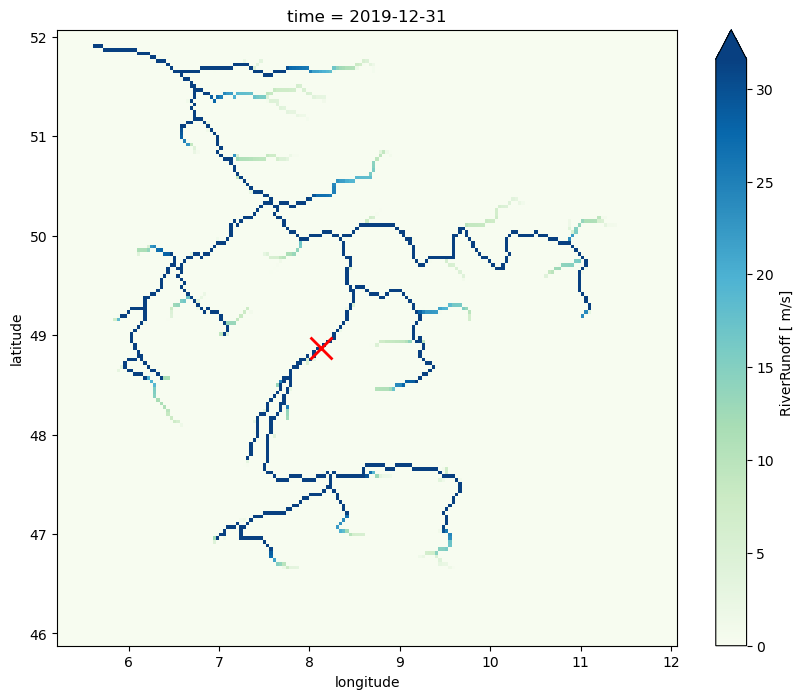

In [34]:
qm = da.plot(robust=True, cmap="GnBu", figsize=(10, 8))

# Coordinates of Iffezheim
target_lon = [8.13]
target_lat = [48.87]
# Add some crosses to check that 'get_value_at_coords' works correctly below
qm.axes.scatter(target_lon, target_lat, s=250, c="r", marker="x", lw=2)

## Locate the gauge closest to iffezheim


In [62]:
import pandas as pd
from pathlib import Path

gauges_path = Path("/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/wflow_20250603_142247/staticmaps/gauges.col")

# Read comma-separated values with three columns: lon, lat, gauge_id
df_gauges = pd.read_csv(gauges_path, sep=",", header=None, names=["lon", "lat", "gauge_id"])
df_gauges["lon"] = df_gauges["lon"].astype(float)
df_gauges["lat"] = df_gauges["lat"].astype(float)
print(df_gauges.head())


lon      lat  gauge_id
0  7.61373  47.5757         1
1  7.89600  50.3170         2
2  9.01000  49.4400         3
3  7.75210  50.0881         4
4  6.96160  50.9417         5

In [63]:
from geopy.distance import geodesic

# Iffezheim coordinates
target_coords = (48.87, 8.13)

# Compute distance from Iffezheim to each gauge
df_gauges["distance_km"] = df_gauges.apply(
    lambda row: geodesic((row["lat"], row["lon"]), target_coords).kilometers,
    axis=1
)

# Sort and show nearest
df_gauges_sorted = df_gauges.sort_values("distance_km")
print(df_gauges_sorted.head(5))

lon      lat  gauge_id  distance_km
9   8.3030  49.0400        10    22.758504
2   9.0100  49.4400         3    90.214945
13  7.9080  49.9140        14   117.223866
6   8.4399  50.0049         7   128.206834
3   7.7521  50.0881         4   138.215512

### Gauge places and iffezheim

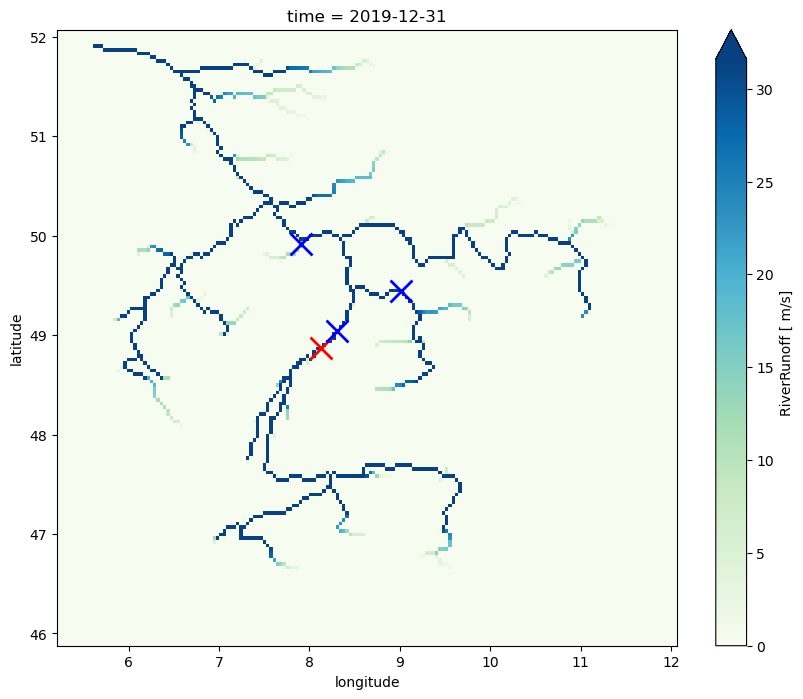

In [81]:
qm = da.plot(robust=True, cmap="GnBu", figsize=(10, 8))

# Coordinates of Iffezheim
target_lon = [8.13]
target_lat = [48.87]
# Add some crosses to check that 'get_value_at_coords' works correctly below
qm.axes.scatter(target_lon, target_lat, s=250, c="r", marker="x", lw=2)

# Coordinates of Gauges
target_lon = [8.3030, 9.0100, 7.9080]
target_lat = [49.0400, 49.4400, 49.9140]
# Add some crosses to check that 'get_value_at_coords' works correctly below
qm.axes.scatter(target_lon, target_lat, s=250, c="b", marker="x", lw=2)

### extract discharge

In [65]:
import pandas as pd

tss_file = "wflow_20250603_142247/run_default/run.tss"  # or update.tss, whichever has all gauges
df = pd.read_csv(tss_file, sep=r"\s+", header=None, skiprows=18)
df.columns = ["Timestep"] + [f"Gauge_{i}" for i in range(1, df.shape[1])]
df["Date"] = pd.date_range(start="2013-11-26", periods=len(df), freq="D")
df.set_index("Date", inplace=True)

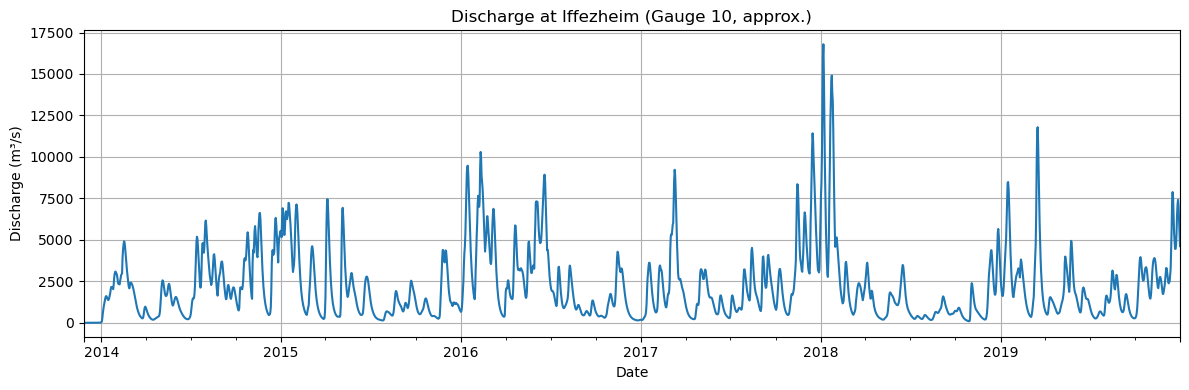

In [66]:
import matplotlib.pyplot as plt

# Plot discharge at Iffezheim (approximate via Gauge_10)
df["Gauge_10"].plot(figsize=(12, 4))
plt.title("Discharge at Iffezheim (Gauge 10, approx.)")
plt.ylabel("Discharge (m³/s)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
## in m3/s?

## Convert to m3/s

In [82]:
import xarray as xr
import numpy as np

# Load staticmaps
ds_static = xr.open_dataset("wflow_20250603_142247/staticmaps.nc")

# Try built-in cell area
if "cell_area" in ds_static:
    area_m2 = ds_static["cell_area"]
    print("Using built-in cell_area")
else:
    # Use lat/lon grid resolution
    lat = ds_static["lat"].values
    lon = ds_static["lon"].values
    dy = abs(lat[1] - lat[0])
    dx = abs(lon[1] - lon[0])
    mean_lat = np.mean(lat)
    lat_m = 111_000
    lon_m = 111_000 * np.cos(np.radians(mean_lat))
    area_m2 = dx * lon_m * dy * lat_m
    print(f"Estimated uniform cell area: {area_m2:.2f} m²")

#Hier gaat wat fout!!

Estimated uniform cell area: 10873286.88 m²

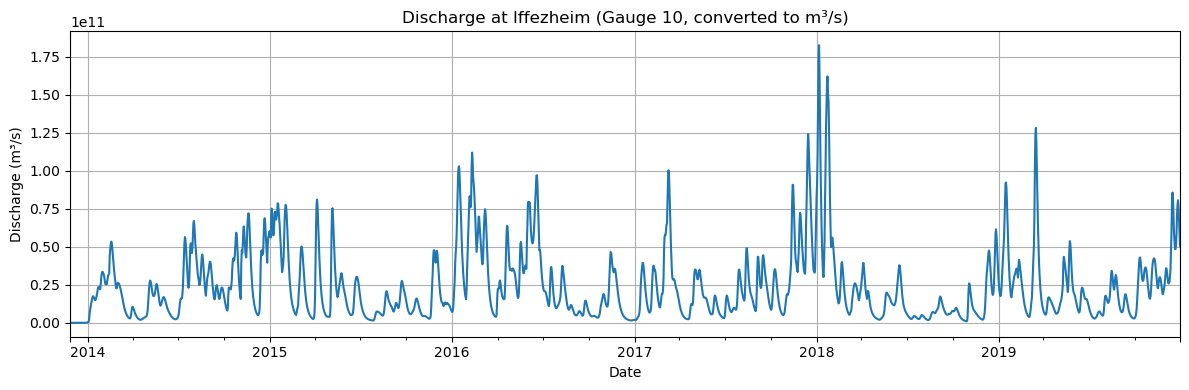

In [76]:
# Convert to m³/s
df["Gauge_10_m3s"] = df["Gauge_10"] * 10873286.88

# Plot
import matplotlib.pyplot as plt
df["Gauge_10_m3s"].plot(figsize=(12, 4))
plt.title("Discharge at Iffezheim (Gauge 10, converted to m³/s)")
plt.ylabel("Discharge (m³/s)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
## This is also way to large, can never be a good fit